# Exercice 1

## Breast cancer

In cancer detection, we want to minimize incorrect negative predictions (i.e. the sick patient is classified as negative) because this diagnosis could lead to serious health problems. Therefore, the most important metric in the application of cancer detection is the recall which objective is to limit the number of false negatives.

### Load data

In [1]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

In [2]:
cancer['target_names']

array(['malignant', 'benign'], dtype='<U9')

**Target**  
'0' => malignant/sick  
'1' => benign/safe

### Preprocessing

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_cancer = pd.DataFrame(data=cancer['data'], columns=cancer['feature_names'])
df_cancer['target'] = cancer['target']

X_train, X_test, y_train, y_test = train_test_split(df_cancer.drop('target', axis=1), df_cancer['target'], test_size=0.2, random_state=42)

/tmp/ipykernel_49431/3993757016.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### Training

#### With hand

##### Bayesian classification

In [5]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

NB_clf = BernoulliNB()
NB_clf.fit(X_train_sc, y_train)
y_pred = NB_clf.predict(X_test_sc)

accuracy_nb = round(accuracy_score(y_test, y_pred), 3)
precision_nb = round(precision_score(y_test, y_pred), 3)
recall_nb = round(recall_score(y_test, y_pred), 3)
f1_nb = round(f1_score(y_test, y_pred), 3)
auc_nb = round(roc_auc_score(y_test, y_pred), 3)

print(f'Accuracy: {accuracy_nb}')
print(f'Precision: {precision_nb}')
print(f'Recall: {recall_nb}')
print(f'F1: {f1_nb}')
print(f'AUC: {auc_nb}')

Accuracy: 0.982
Precision: 0.986
Recall: 0.986
F1: 0.986
AUC: 0.981


##### Decision Tree

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

best_recall = 0

param_values = {
    'max_depth' : range(1, X_train_sc.shape[1] + 1),
}

for depth in param_values['max_depth']:
    dc = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dc.fit(X_train_sc, y_train)
    recalls = cross_val_score(dc, X_train_sc, y_train, cv=10, scoring='recall')
    recall = recalls.mean()
    if recall > best_recall:
        best_recall = recall
        best_depth = depth
        best_dc = dc

In [7]:
print(f"Best depth: {best_depth}")

Best depth: 5


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = best_dc.predict(X_test_sc)

accuracy_dt = round(accuracy_score(y_test, y_pred), 3)
precision_dt = round(precision_score(y_test, y_pred), 3)
recall_dt = round(recall_score(y_test, y_pred), 3)
f1_dt = round(f1_score(y_test, y_pred), 3)
auc_dt = round(roc_auc_score(y_test, y_pred), 3)

print(f'Accuracy: {accuracy_dt}')
print(f'Precision: {precision_dt}')
print(f'Recall: {recall_dt}')
print(f'f1: {f1_dt}')
print(f'AUC: {auc_dt}')

Accuracy: 0.947
Precision: 0.958
Recall: 0.958
f1: 0.958
AUC: 0.944


##### Random Forest

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

best_recall = 0

param_values = {
    'max_depth' : range(1, X_train_sc.shape[1] + 1),
}
for depth in tqdm(param_values['max_depth']):
    rf = RandomForestClassifier(max_depth=depth, n_jobs=-1, random_state=42)
    rf.fit(X_train_sc, y_train)
    recalls = cross_val_score(rf, X_train_sc, y_train, cv=10, scoring='recall')
    recall = recalls.mean()
    if recall > best_recall:
        best_recall = recall
        best_depth = depth
        best_rf = rf

100%|██████████| 30/30 [01:03<00:00,  2.13s/it]


In [10]:
print(f"Best depth: {best_depth}")

Best depth: 6


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = best_rf.predict(X_test_sc)

accuracy_rf = round(accuracy_score(y_test, y_pred), 3)
precision_rf = round(precision_score(y_test, y_pred), 3)
recall_rf = round(recall_score(y_test, y_pred), 3)
f1_rf = round(f1_score(y_test, y_pred), 3)
auc_rf = round(roc_auc_score(y_test, y_pred), 3)

print(f'Accuracy: {accuracy_rf}')
print(f'Precision: {precision_rf}')
print(f'Recall: {recall_rf}')
print(f'f1: {f1_rf}')
print(f'AUC: {auc_rf}')


Accuracy: 0.965
Precision: 0.959
Recall: 0.986
f1: 0.972
AUC: 0.958


##### XG Boost

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm

best_recall = 0

param_values = {
    'max_depth' : range(1, X_train_sc.shape[1] + 1),
}

for depth in tqdm(param_values['max_depth']):
    gb = GradientBoostingClassifier(max_depth=depth, random_state=42)
    gb.fit(X_train_sc, y_train)
    recalls = cross_val_score(gb, X_train_sc, y_train, cv=10, scoring='recall')
    recall = recalls.mean()
    if recall > best_recall:
        best_recall = recall
        best_depth = depth
        best_gb = gb

100%|██████████| 30/30 [02:54<00:00,  5.82s/it]


In [13]:
print(f"Best depth: {best_depth}")

Best depth: 1


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = best_gb.predict(X_test_sc)

accuracy_gb = round(accuracy_score(y_test, y_pred), 3)
precision_gb = round(precision_score(y_test, y_pred), 3)
recall_gb = round(recall_score(y_test, y_pred), 3)
f1_gb = round(f1_score(y_test, y_pred), 3)
auc_gb = round(roc_auc_score(y_test, y_pred), 3)

print(f'Accuracy: {accuracy_gb}')
print(f'Precision: {precision_gb}')
print(f'Recall: {recall_gb}')
print(f'f1: {f1_gb}')
print(f'AUC: {auc_gb}')

Accuracy: 0.956
Precision: 0.958
Recall: 0.972
f1: 0.965
AUC: 0.951


In [15]:

results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
results.loc[0] = ["Naive Bayes", accuracy_nb, precision_nb, recall_nb, f1_nb, auc_nb]
results.loc[1] = ["Decision Tree", accuracy_dt, precision_dt, recall_dt, f1_dt, auc_dt]
results.loc[2] = ["Random Forest", accuracy_rf, precision_rf, recall_rf, f1_rf, auc_rf]
results.loc[3] = ["Gradient Boosting", accuracy_gb, precision_gb, recall_gb, f1_gb, auc_gb]

print(results.to_string(index=False))


            Model  Accuracy  Precision  Recall  f1-score   AUC
      Naive Bayes     0.982      0.986   0.986     0.986 0.981
    Decision Tree     0.947      0.958   0.958     0.958 0.944
    Random Forest     0.965      0.959   0.986     0.972 0.958
Gradient Boosting     0.956      0.958   0.972     0.965 0.951


#### With GridSearchCV

In [16]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

grid_nb = {}

grid_dt = {
    'max_depth': range(1, X_train_sc.shape[1] + 1)
}

grid_rf = {
    'max_depth': range(1, X_train_sc.shape[1] + 1)
}

grid_gb = {
    'max_depth': range(1, X_train_sc.shape[1] + 1)
}

models_name = ["Naive Bayes", "Decision Tree", "Random Forest", "Gradient Boosting"]
grids = [grid_nb, grid_dt, grid_rf, grid_gb]
models = [
    GridSearchCV(BernoulliNB(), grid_nb, cv=10, n_jobs=-1, scoring='recall'),
    GridSearchCV(DecisionTreeClassifier(random_state=42), grid_dt, cv=10, n_jobs=-1, scoring='recall'),
    GridSearchCV(RandomForestClassifier(random_state=42), grid_rf, cv=10, n_jobs=-1, scoring='recall'),
    GridSearchCV(GradientBoostingClassifier(random_state=42), grid_gb, cv=10, n_jobs=-1, scoring='recall')
]

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])

for i, (model_name, model, grid) in enumerate(zip(models_name, models, grids)):
    model.fit(X_train_sc, y_train)
    y_pred = model.predict(X_test_sc)

    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    roc_auc = round(roc_auc_score(y_test, y_pred), 3)

    results.loc[i] = [model_name, accuracy, precision, recall, f1, roc_auc]

In [18]:
for model_name, model in zip(models_name, models):
    print(f"Best parameters for {model_name}: {model.best_params_}")

Best parameters for Naive Bayes: {}
Best parameters for Decision Tree: {'max_depth': 5}
Best parameters for Random Forest: {'max_depth': 6}
Best parameters for Gradient Boosting: {'max_depth': 1}


## Results

In [19]:
print(results.to_string(index=False))

            Model  Accuracy  Precision  Recall  f1-score   AUC
      Naive Bayes     0.982      0.986   0.986     0.986 0.981
    Decision Tree     0.947      0.958   0.958     0.958 0.944
    Random Forest     0.965      0.959   0.986     0.972 0.958
Gradient Boosting     0.956      0.958   0.972     0.965 0.951


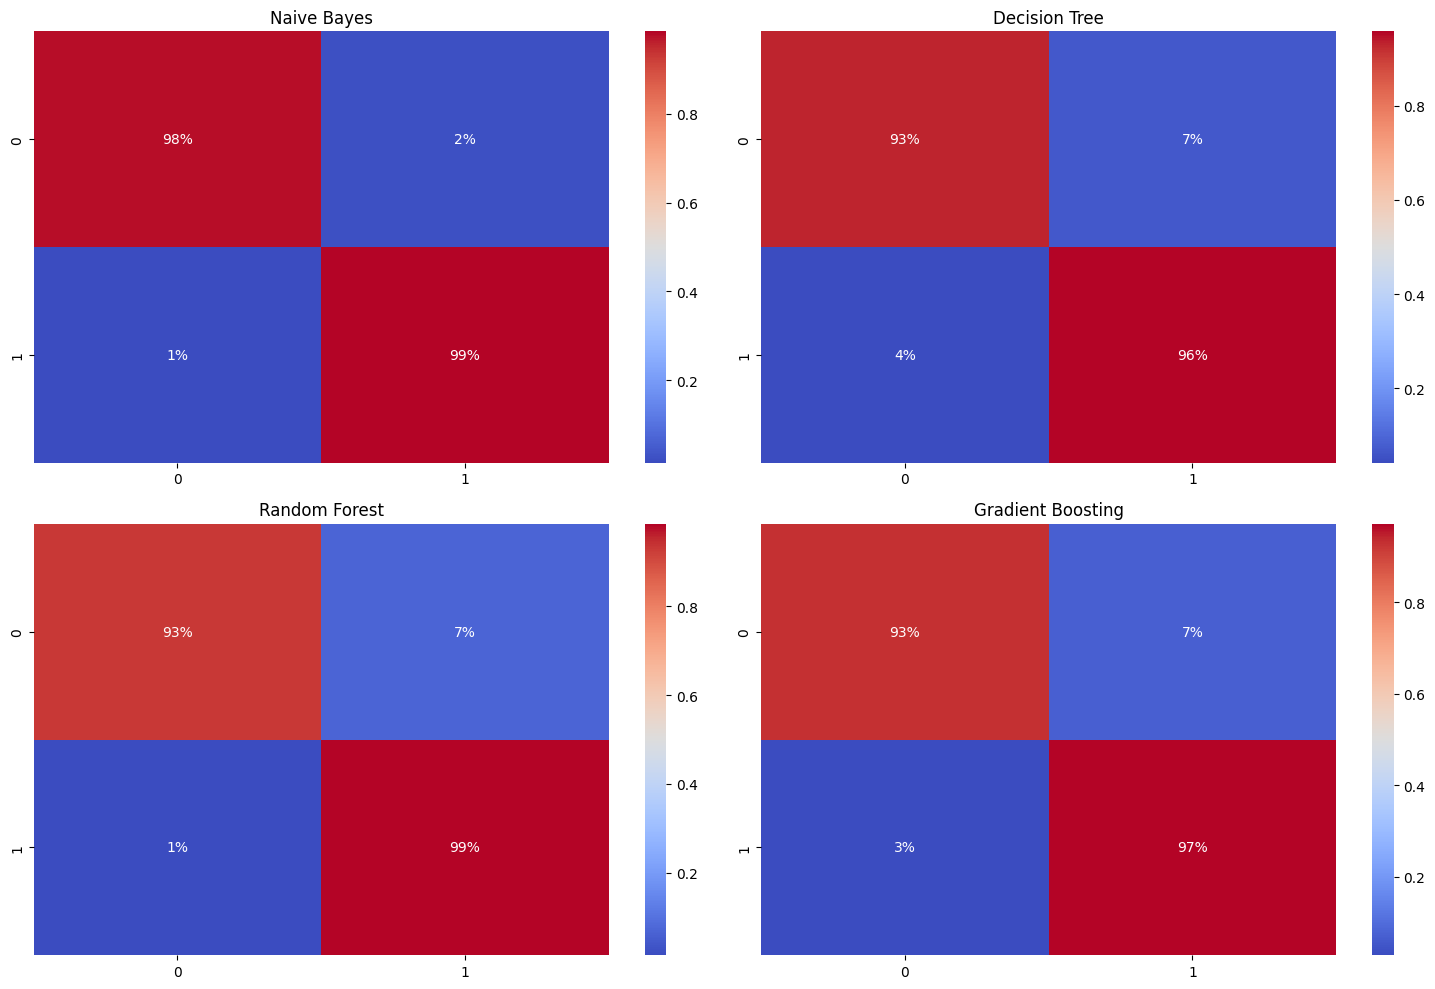

In [20]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, model in enumerate(models):
    y_pred = model.predict(X_test_sc)
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.0%', ax=axes[i//2, i%2], cmap='coolwarm')
    axes[i//2, i%2].set_title(models_name[i])
    
plt.tight_layout()
plt.show()

We obtain better a better recall with the **Naive Bayes** model so we choose this this model.

## Boston Housing

### Load data

In [21]:
import mglearn
X, y = mglearn.datasets.load_extended_boston()

### Preprocessing

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Training

#### With hand

##### Bayesian Regression

In [23]:
# TODO

##### Decision Tree

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

best_r2 = 0

param_values = {
    'max_depth': range(1, X_train.shape[1] + 1)
}

for depth in param_values['max_depth']:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)

    r2s = cross_val_score(dt, X_train, y_train, cv=10, scoring='r2')
    r2 = r2s.mean()
    if r2 > best_r2:
        best_r2 = r2
        best_depth = depth
        best_dt = dt

In [25]:
print(f"Best depth: {best_depth}")

Best depth: 10


In [26]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np

y_pred = best_dt.predict(X_test)

mape_dt = mean_absolute_percentage_error(y_test, y_pred)
rmse_dt = round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)
r2_dt = round(r2_score(y_test, y_pred), 3)

print(f"MAPE : {mape_dt}")
print(f"RMSE : {rmse_dt}")
print(f"r2 : {r2_dt}")

MAPE : 0.12460414024049826
RMSE : 3.599
r2 : 0.823


##### Random Forest

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

best_r2 = 0

param_values = {
    'max_depth': range(1, X_train.shape[1] + 1)
}

for depth in tqdm(param_values['max_depth']):
    rf = RandomForestRegressor(max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)

    r2s = cross_val_score(rf, X_train, y_train, cv=10, scoring='r2')
    r2 = r2s.mean()
    if r2 > best_r2:
        best_r2 = r2
        best_depth = depth
        best_rf = rf

In [28]:
print(f"Best depth: {best_depth}")

Best depth: 16


In [29]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np

y_pred = best_rf.predict(X_test)

mape_rf = mean_absolute_percentage_error(y_test, y_pred)
rmse_rf = round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)
r2_rf = round(r2_score(y_test, y_pred), 3)

print(f"MAPE : {mape_rf}")
print(f"RMSE : {rmse_rf}")
print(f"r2 : {r2_rf}")

MAPE : 0.10316796164137343
RMSE : 2.838
r2 : 0.89


##### XG Boost

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

best_r2 = 0

param_values = {
    'max_depth': range(1, X_train.shape[1] + 1)
}

for depth in param_values['max_depth']:
    gb = GradientBoostingRegressor(max_depth=depth, random_state=42)
    gb.fit(X_train, y_train)

    r2s = cross_val_score(gb, X_train, y_train, cv=10, scoring='r2')
    r2 = r2s.mean()
    if r2 > best_r2:
        best_r2 = r2
        best_depth = depth
        best_gb = gb

In [ ]:
print(f"Best depth: {best_depth}")

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np

y_pred = best_gb.predict(X_test)

mape_gb = mean_absolute_percentage_error(y_test, y_pred)
rmse_gb = round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)
r2_gb = round(r2_score(y_test, y_pred), 3)

print(f"MAPE : {mape_gb}")
print(f"RMSE : {rmse_gb}")
print(f"r2 : {r2_gb}")

In [ ]:
results = pd.DataFrame(columns=["Model", "MAPE", "MSE", "r2"])
results.loc[0] = ["Decision Tree", mape_dt, rmse_dt, r2_dt]
results.loc[1] = ["Random Forest", mape_rf, rmse_rf, r2_rf]
results.loc[2] = ["Gradient Boosting", mape_gb, rmse_gb, r2_gb]

print(results.to_string(index=False))

#### With GridSearchCV

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV

grid_dt = {
    'max_depth': range(1, X_train.shape[1] + 1)
}

grid_rf = {
    'max_depth': range(1, X_train.shape[1] + 1)
}

grid_gb = {
    'max_depth': range(1, X_train.shape[1] + 1)
}

models_name = ["Decision Tree", "Random Forest", "Gradient Boosting"]
grids = [grid_dt, grid_rf, grid_gb]

models = [
    GridSearchCV(DecisionTreeRegressor(random_state=42), grid_dt, cv=10, n_jobs=-1, scoring='r2'),
    GridSearchCV(RandomForestRegressor(random_state=42), grid_rf, cv=10, n_jobs=-1, scoring='r2'),
    GridSearchCV(GradientBoostingRegressor(random_state=42), grid_gb, cv=10, n_jobs=-1, scoring='r2')
]

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

results = pd.DataFrame(columns=["Model", "MAPE", "RMSE", "r2"])

for i, (model_name, model, grid) in enumerate(zip(models_name, models, grids)):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mape = round(mean_absolute_percentage_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)
    r2 = round(r2_score(y_test, y_pred), 3)

    results.loc[i] = [model_name, mape, rmse, r2]

In [ ]:
for model_name, model in zip(models_name, models):
    print(f"Best parameters for {model_name}: {model.best_params_}")

In [ ]:
print(results.to_string(index=False))